# Ridge regression with polynomial features of degree 2
**Important**: Change the kernel to *PROJECT_NAME local*. You can do this from the *Kernel* menu under *Change kernel*.

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
import pickle
import os
import scipy.stats as st

In [ ]:
from azureml.logging import get_azureml_logger
run_logger = get_azureml_logger()
run_logger.log('amlrealworld.timeseries.ridge-poly','true')

In [3]:
model_name = "ridge_poly2"
aml_dir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']
train = pd.read_csv(os.path.join(aml_dir, 'nyc_demand_train.csv'), parse_dates=['timeStamp'])

Create model pipeline:
- one-hot encode categorical features.
- create polynomial features of degree 2. This means that for each pair of features $(x_1, x_2)$, the output features are $(x_1, x_2, x_1^2, x_1x_2, x_2^2)$
- randomized parameter search with cross validation to find optimal values for the alpha parameter

Note - to limit the training time, the number of iterations for the randomized search has been set to 20. This should train in about 3 minutes. increasing the number of iterations will increase the likelihood of finding the optimum solution but also increase training times. 

In [4]:
X = train.drop(['demand', 'timeStamp'], axis=1)

In [5]:
cat_cols = ['hour', 'month', 'dayofweek']
cat_cols_idx = [X.columns.get_loc(c) for c in X.columns if c in cat_cols]
onehot = OneHotEncoder(categorical_features=cat_cols_idx, sparse=False)
regr = Ridge(fit_intercept=False)
poly = PolynomialFeatures(2)
tscv = TimeSeriesSplit(n_splits=3)

In [6]:
param_dist = {'alpha': st.uniform(1e-4, 5.0)}
regr_cv = RandomizedSearchCV(estimator=regr,
                            param_distributions=param_dist,
                            n_iter=20,
                            scoring='neg_mean_squared_error',
                            iid=False,
                            cv=tscv,
                            verbose=2,
                            n_jobs=-1)
regr_pipe = Pipeline([('onehot', onehot), ('poly', poly), ('regr_cv', regr_cv)])
regr_pipe.fit(X, y=train['demand'])

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.8min finished


Pipeline(steps=[('onehot', OneHotEncoder(categorical_features=[2, 3, 4], dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)), ('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('regr_cv', RandomizedSearchCV(cv=TimeSeriesSplit(n_splits...it=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=2))])

In [7]:
with open(os.path.join(aml_dir, model_name + '.pkl'), 'wb') as f:
    pickle.dump(regr_pipe, f)

Cross validation results

In [8]:
cv_results = pd.DataFrame(regr_pipe.named_steps['regr_cv'].cv_results_)
cv_results.sort_values(by='rank_test_score').head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
3,5.566205,0.055169,-1248.340799,-1049.203255,1.47168,{'alpha': 1.47167593681},1,-1375.363645,-1020.576316,-1078.777783,-1080.560352,-1290.880968,-1046.473098,1.684181,0.006250,124.761220,24.564357
14,6.434544,0.075168,-1248.497834,-1049.756123,1.54166,{'alpha': 1.54166210236},2,-1375.791197,-1021.562751,-1078.841152,-1080.961630,-1290.861154,-1046.743987,2.068280,0.018967,124.875459,24.342849
12,6.040374,0.062836,-1249.025435,-1040.058227,0.435558,{'alpha': 0.435558001169},3,-1375.874522,-1004.815998,-1078.455770,-1073.551296,-1292.746012,-1041.807388,1.761688,0.003172,125.294573,28.088313
2,5.495538,0.058334,-1249.697691,-1052.917046,1.94805,{'alpha': 1.94805364999},4,-1378.926229,-1027.234624,-1079.282461,-1083.246796,-1290.884382,-1048.269718,1.592447,0.006382,125.748040,23.101791
18,5.669536,0.057334,-1250.347488,-1054.273219,2.12472,{'alpha': 2.12472055851},5,-1380.573672,-1029.677671,-1079.512717,-1084.226930,-1290.956075,-1048.915056,1.239390,0.007262,126.217320,22.589641


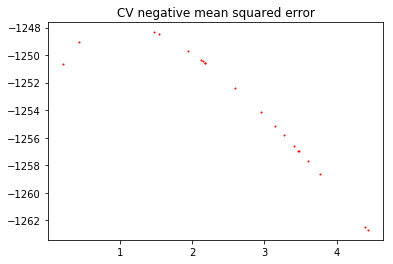

In [9]:
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], 'ro', markersize=1)
plt.title('CV negative mean squared error')
plt.show()